# Introduction

In a prior notebook, documents were partitioned by assigning them to the domain with the highest Dice similarity of their term and structure occurrences. Here, we'll assess whether the observed modularity of the partitions is greater than expected by chance. Modularity will be measured by the ratio of dispersion between partitions to dispersion within partitions.

# Load the data

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)

import sys
sys.path.append("..")
import utilities, modularity

In [2]:
framework = "data-driven" 
version = 190325 # Document-term matrix version
suffix = "" # Suffix for term lists
n_iter = 1000 # Iterations for bootstrap and null
dx = [0.36, 0.35, 0.38, 0.38, 0.34, 0.35] # Nudges for plotted means
ds = 0.09 # Nudges for plotted stars
alpha = 0.001 # Significance level for statistical comparisons

## Brain activation coordinates

In [3]:
act_bin = utilities.load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=114


## Document-term matrix

In [4]:
dtm_bin = utilities.load_doc_term_matrix(version=version, binarize=True)
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=4107


## Domain archetypes

In [5]:
from collections import OrderedDict

In [6]:
lists, circuits = utilities.load_framework(framework, suffix=utilities.suffix[framework])

In [7]:
words = sorted(list(set(lists["TOKEN"])))
structures = sorted(list(set(act_bin.columns)))
domains = list(OrderedDict.fromkeys(lists["DOMAIN"]))

In [8]:
archetypes = pd.DataFrame(0.0, index=words+structures, columns=domains)
for dom in domains:
    for word in lists.loc[lists["DOMAIN"] == dom, "TOKEN"]:
        archetypes.loc[word, dom] = 1.0
    for struct in structures:
        archetypes.loc[struct, dom] = circuits.loc[struct, dom]
archetypes[archetypes > 0.0] = 1.0
print("Term & Structure N={}, Domain N={}".format(
      archetypes.shape[0], archetypes.shape[1]))

Term & Structure N=197, Domain N=6


## Document structure-term vectors

In [9]:
pmids = dtm_bin.index.intersection(act_bin.index)
len(pmids)

18155

In [10]:
dtm_words = dtm_bin.loc[pmids, words]
act_structs = act_bin.loc[pmids, structures]

In [11]:
docs = dtm_words.copy()
docs[structures] = act_structs.copy()
docs.head()

,action,addiction,anhedonia,anticipation,arousal,attention,audition,auditory_perception,autobiographical_memory,cognitive_control,...,right_superior_temporal_gyrus_posterior_division,right_supplementary_motor_cortex,right_supracalcarine_cortex,right_supramarginal_gyrus_anterior_division,right_supramarginal_gyrus_posterior_division,right_temporal_fusiform_cortex_anterior_division,right_temporal_fusiform_cortex_posterior_division,right_temporal_occipital_fusiform_cortex,right_temporal_pole,right_thalamus
10022492,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,0,0,0,1
10022494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1,1,1,0,0,0,1,0,0
10022496,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0
10027301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
10051677,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,1,0,1,1


## Dice distances

In [12]:
from scipy.spatial.distance import cdist

In [13]:
doc_dists = cdist(docs, docs, metric="dice")
doc_dists = pd.DataFrame(doc_dists, index=pmids, columns=pmids)

## Document assignments

In [14]:
doc2dom_df = pd.read_csv("../partition/data/doc2dom_{}.csv".format(framework), 
                         header=None, index_col=0)
doc2dom = {int(pmid): int(dom) for pmid, dom in doc2dom_df.iterrows()}

In [15]:
dom2docs = {dom: [] for dom in domains}
for doc, dom in doc2dom.items():
    dom2docs[domains[dom-1]].append(doc)

In [16]:
sorted_pmids = []
for dom in range(len(domains)):
    sorted_pmids += [pmid for pmid, sys in doc2dom.items() if sys == dom + 1]

# Sort distances

Indexing by min:max will be faster in subsequent computations

## Reorder by domain PMIDs

In [17]:
doc_dists = doc_dists[sorted_pmids].loc[sorted_pmids]

## Compute domain min and max indices

In [18]:
dom_idx = {dom: {"min": 0, "max": 0} for dom in domains}
for dom in domains:
    dom_pmids = dom2docs[dom]
    dom_idx[dom]["min"] = sorted_pmids.index(dom_pmids[0])
    dom_idx[dom]["max"] = sorted_pmids.index(dom_pmids[-1]) + 1

# Compute domain modularity

## Observed values

In [19]:
dists_int, dists_ext = {}, {}
df_obs = pd.DataFrame(index=domains, columns=pmids)
df = pd.DataFrame(index=domains, columns=["OBSERVED"])

for dom in domains:
    
    dom_min, dom_max = dom_idx[dom]["min"], dom_idx[dom]["max"]
    dom_dists = doc_dists.values[:,dom_min:dom_max][dom_min:dom_max,:]
    dists_int[dom] = dom_dists.ravel()
    dist_int = np.nanmean(dom_dists)
    doc_dists_int = np.mean(dom_dists, axis=0)
    
    other_dists_lower = doc_dists.values[:,dom_min:dom_max][:dom_min,:]
    other_dists_upper = doc_dists.values[:,dom_min:dom_max][dom_max:,:]
    other_dists = np.concatenate((other_dists_lower, other_dists_upper))
    dists_ext[dom] = other_dists.ravel()
    dist_ext = np.nanmean(other_dists)
    doc_dists_ext = np.mean(other_dists, axis=0)
    
    df.loc[dom, "OBSERVED"] = dist_ext / dist_int
    df_obs.loc[dom, dom2docs[dom]] = doc_dists_ext / doc_dists_int
    
df.to_csv("data/mod_obs_{}.csv".format(framework))
df.head(6)

,OBSERVED
MEMORY,1.06766
REWARD,1.08348
REACTION_TIME,1.03562
MANIPULATION,1.15843
VISION,1.10173
LANGUAGE,1.13994


In [20]:
df["OBSERVED"].mean()

1.0978105915650993

## Null distributions

In [21]:
import os

In [22]:
null_dists = doc_dists.values.copy()
file_null = "data/mod_null_{}_{}iter.csv".format(framework, n_iter)
if not os.path.isfile(file_null):
    
    df_null = np.empty((len(domains), n_iter))
    
    for n in range(n_iter):
        np.random.shuffle(null_dists)
        
        for i, dom in enumerate(domains):
            
            dom_min, dom_max = dom_idx[dom]["min"], dom_idx[dom]["max"]
            dom_dists = null_dists[:,dom_min:dom_max][dom_min:dom_max,:]
            dist_int = np.nanmean(dom_dists)

            other_dists_lower = null_dists[:,dom_min:dom_max][:dom_min,:]
            other_dists_upper = null_dists[:,dom_min:dom_max][dom_max:,:]
            other_dists = np.concatenate((other_dists_lower, other_dists_upper))
            dist_ext = np.nanmean(other_dists)
            
            df_null[i,n] = dist_ext / dist_int
            
        if n % int(n_iter / 10.0) == 0:
            print("Processed {} iterations".format(n))
    
    df_null = pd.DataFrame(df_null, index=domains, columns=range(n_iter))
    df_null.to_csv(file_null)

else:
    df_null = pd.read_csv(file_null, index_col=0, header=0)

## Bootstrap distributions

In [23]:
file_boot = "data/mod_boot_{}_{}iter.csv".format(framework, n_iter)
if not os.path.isfile(file_boot):
    df_boot = np.empty((len(domains), n_iter))
    
    for n in range(n_iter):
        for i, dom in enumerate(domains):
            
            boot_int = np.random.choice(dists_int[dom], size=len(dists_int[dom]), replace=True)
            dist_int = np.nanmean(boot_int)
            
            boot_ext = np.random.choice(dists_ext[dom], size=len(dists_ext[dom]), replace=True)
            dist_ext = np.nanmean(boot_ext)
            
            df_boot[i,n] = dist_ext / dist_int
            
        if n % int(n_iter / 10.0) == 0:
            print("Processed {} iterations".format(n))
            
    df_boot = pd.DataFrame(df_boot, index=domains, columns=range(n_iter))
    df_boot.to_csv(file_boot)

else:
    df_boot = pd.read_csv(file_boot, index_col=0, header=0)

# Perform significance testing

In [24]:
from statsmodels.stats import multitest

In [25]:
pval = []
for dom in domains:   
    dom_null = df_null.loc[dom].values
    dom_obs = float(df.loc[dom, "OBSERVED"])
    p = np.sum(dom_null >= dom_obs) / float(n_iter)
    pval.append(p)
    df.loc[dom, "P"] = p
df["FDR"] = multitest.multipletests(pval, method="fdr_bh")[1]
for dom in domains:
    if df.loc[dom, "FDR"] < alpha:
        df.loc[dom, "STARS"] = "*"
    else:
        df.loc[dom, "STARS"] = ""
df = df.loc[domains, ["OBSERVED", "P", "FDR", "STARS"]]
df

,OBSERVED,P,FDR,STARS
MEMORY,1.06766,0.0,0.0,*
REWARD,1.08348,0.0,0.0,*
REACTION_TIME,1.03562,0.0,0.0,*
MANIPULATION,1.15843,0.0,0.0,*
VISION,1.10173,0.0,0.0,*
LANGUAGE,1.13994,0.0,0.0,*


# Plot results

In [26]:
%matplotlib inline

In [27]:
palette = utilities.palettes[framework]

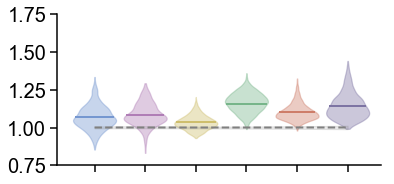

In [28]:
modularity.plot_violins(framework, domains, df, df_null, df_obs, palette, 
                        dx=dx, ds=ds, alphas=[0], interval=0.999,
                        ylim=[0.75,1.75], yticks=[0.75,1,1.25,1.5,1.75])